In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

%matplotlib inline

In [2]:
np.random.seed(2022)

# 1. Brain Cancer Data

In [3]:
brain_cancer = pd.read_csv('data/BrainCancer.csv', index_col=0)
brain_cancer.head()

,sex,diagnosis,loc,ki,gtv,stereo,status,time
1,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
2,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
3,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
4,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
5,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


In [4]:
brain_cancer.columns

Index(['sex', 'diagnosis', 'loc', 'ki', 'gtv', 'stereo', 'status', 'time'], dtype='object')

In [5]:
brain_cancer['sex'].value_counts()

Female    45
Male      43
Name: sex, dtype: int64

In [6]:
brain_cancer['diagnosis'].value_counts()

Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64

In [7]:
brain_cancer['status'].value_counts()

0    53
1    35
Name: status, dtype: int64

In [8]:
kmf = KaplanMeierFitter()
kmf.fit(brain_cancer['time'], brain_cancer['status'], label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 88 total observations, 53 right-censored observations>

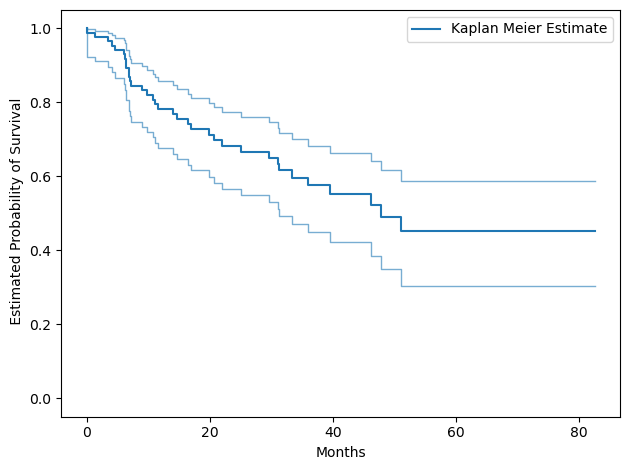

In [9]:
kmf.plot(ci_force_lines=True)
plt.xlabel('Months')
plt.ylim(-0.05, 1.05)
plt.ylabel(' Estimated Probability of Survival')
plt.tight_layout()

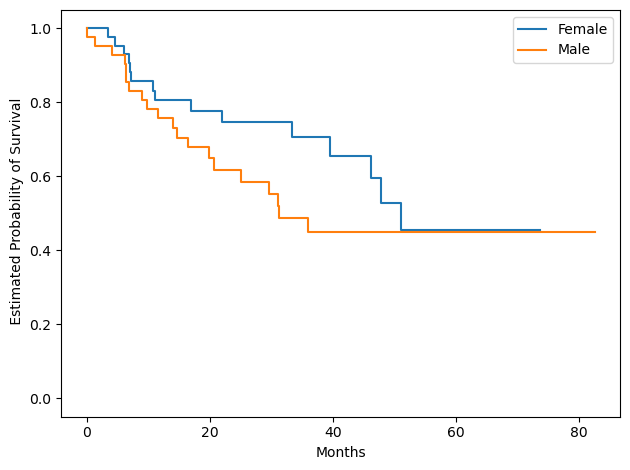

In [10]:
kmf1 = KaplanMeierFitter() 

groups = brain_cancer['sex'] 
T = brain_cancer.time
E = brain_cancer.status  
i1 = (groups == 'Female')     
i2 = (groups == 'Male')     

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Female')
a1 = kmf1.plot(ci_show=False)

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Male')
kmf1.plot(ax=a1, ci_show=False)

plt.xlabel('Months')
plt.ylim(-0.05, 1.05)
plt.ylabel(' Estimated Probability of Survival')
plt.tight_layout()

In [11]:
results=logrank_test(
    T[i1], T[i2],
    event_observed_A=E[i1], event_observed_B=E[i2]
)
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

In [12]:
df_dummy = pd.get_dummies(brain_cancer, drop_first=True)
df_dummy.head()

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
1,90,6.11,0,57.64,0,0,1,0,0,0
2,90,19.35,1,8.98,1,0,0,0,1,1
3,70,7.95,0,26.46,0,0,1,0,0,0
4,80,7.61,1,47.80,0,1,0,0,1,1
5,90,5.06,1,6.30,1,0,0,0,1,1


In [13]:
cph1 = CoxPHFitter()   
cph1.fit(df_dummy[['status', 'sex_Male', 'time']], 'time', event_col='status')   
cph1.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -137.43
         time fit was run = 2022-11-01 16:41:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex_Male    0.41       1.50       0.34            -0.26             1.08                 0.77                 2.94

            cmp to    z    p   -log2(p)
covariate                              
sex_Male      0.00 1.19 0.23       2.10
---
Concordance = 0.56
Partial AIC = 276.86
log-likelihood ratio test = 1.44 on 1 df
-log2(p) of ll-ratio test = 2.12

In [14]:
results.test_statistic

1.4404951070795842

In [15]:
cph2 = CoxPHFitter()   
cph2.fit(df_dummy, 'time', event_col='status')   
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 88 total observations, 53 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 88
number of events observed = 35
   partial log-likelihood = -118.41
         time fit was run = 2022-11-01 16:41:21 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
ki                    -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
gtv                    0.04       1.04       0.02            -0.01             0.08                 0.99                 1.08
sex_Male               0.10       1.10       0.36            -0.61             0.80                 0.54                 2.24
diagnosis_LG glioma   -1.09       0.34       0.57            -2.22             0.03                 0.11                 1.03
diagnosis_Meningioma  -2.08       0.12       0.45            -2.97            -1.19                 0.05                 0.30
diagnosis_Other       -1.24       0.29       0.63            -2.46            -0.01                 0.09                 0.99
loc_Supratentorial     0.38       1.46       0.70            -0.99             1.74                 0.37                 5.72
stereo_SRT             0.14       1.15       0.60            -1.03             1.31                 0.36                 3.71

                       cmp to     z      p   -log2(p)
covariate                                            
ki                       0.00 -3.16 <0.005       9.32
gtv                      0.00  1.59   0.11       3.17
sex_Male                 0.00  0.27   0.79       0.35
diagnosis_LG glioma      0.00 -1.90   0.06       4.13
diagnosis_Meningioma     0.00 -4.59 <0.005      17.78
diagnosis_Other          0.00 -1.97   0.05       4.37
loc_Supratentorial       0.00  0.54   0.59       0.76
stereo_SRT               0.00  0.23   0.82       0.29
---
Concordance = 0.79
Partial AIC = 252.82
log-likelihood ratio test = 39.47 on 8 df
-log2(p) of ll-ratio test = 17.93

In [16]:
modaldata = pd.DataFrame({
    'diagnosis': brain_cancer['diagnosis'].dropna().unique(),
    'sex': 'Female',
    'loc': ' Supratentorial',
    'ki': brain_cancer['ki'].mean(),
    'gtv': brain_cancer['gtv'].mean(),
    'stereo': 'SRT'
})

modaldata

,diagnosis,sex,loc,ki,gtv,stereo
0,Meningioma,Female,Supratentorial,81.022727,8.660795,SRT
1,HG glioma,Female,Supratentorial,81.022727,8.660795,SRT
2,LG glioma,Female,Supratentorial,81.022727,8.660795,SRT
3,Other,Female,Supratentorial,81.022727,8.660795,SRT


In [17]:
pd.get_dummies(modaldata, drop_first=True).assign(sex_Male=0, stereo_SRT=1, loc_Supratentorial=1)

,ki,gtv,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,sex_Male,stereo_SRT,loc_Supratentorial
0,81.022727,8.660795,0,1,0,0,1,1
1,81.022727,8.660795,0,0,0,0,1,1
2,81.022727,8.660795,1,0,0,0,1,1
3,81.022727,8.660795,0,0,1,0,1,1


In [18]:
survivals = cph2.predict_survival_function(
    pd.get_dummies(modaldata, drop_first=True).assign(
        sex_Male=0, stereo_SRT=1, loc_Supratentorial=1
    )
)

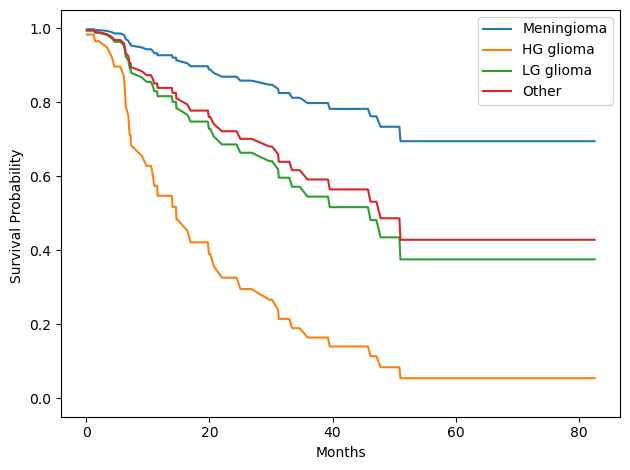

In [19]:
survivals.rename(columns={
    0: 'Meningioma',
    1: 'HG glioma',
    2: 'LG glioma',
    3: 'Other'
}).plot.line(ylim=(-0.05, 1.05), xlabel='Months', ylabel='Survival Probability ')

plt.tight_layout()

# 2. Publication Data

In [20]:
publication = pd.read_csv('data/Publication.csv', index_col=0)
publication.head()

,posres,multi,clinend,mech,sampsize,budget,impact,time,status
1,0,0,1,R01,39876,8.016941,44.016,11.203285,1
2,0,0,1,R01,39876,8.016941,23.494,15.178645,1
3,0,0,1,R01,8171,7.612606,8.391,24.410678,1
4,0,0,1,Contract,24335,11.771928,15.402,2.595483,1
5,0,0,1,Contract,33357,76.517537,16.783,8.607803,1


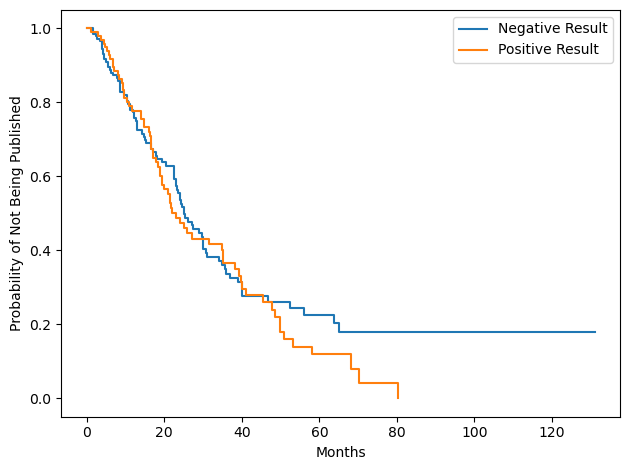

In [21]:
kmf1 = KaplanMeierFitter() 

groups = publication['posres']
T = publication['time']
E = publication['status'] 
i1 = (groups == 0)     
i2 = (groups == 1)     

## fit the model for 1st cohort
kmf1.fit(T[i1], E[i1], label='Negative Result')
a1 = kmf1.plot(ci_show=False)

## fit the model for 2nd cohort
kmf1.fit(T[i2], E[i2], label='Positive Result')
kmf1.plot(ax=a1, ci_show=False)

plt.xlabel('Months')
plt.ylim(-0.05, 1.05)
plt.ylabel('Probability of Not Being Published')
plt.tight_layout()

In [22]:
cox1 = CoxPHFitter()

cox1.fit(
    publication[['time', 'status', 'posres']],
    duration_col='time',
    event_col='status'
)
cox1.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -723.47
         time fit was run = 2022-11-01 16:41:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.15       1.16       0.16            -0.17             0.46                 0.84                 1.59

            cmp to    z    p   -log2(p)
covariate                              
posres        0.00 0.92 0.36       1.48
---
Concordance = 0.50
Partial AIC = 1448.95
log-likelihood ratio test = 0.83 on 1 df
-log2(p) of ll-ratio test = 1.47

In [23]:
logrank_test(T[i1], T[i2], E[i1], E[i2])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.84 0.36      1.48

In [24]:
cox2 = CoxPHFitter()

cox2.fit(
    publication.drop(columns='mech'),
    duration_col='time',
    event_col='status'
)
cox2.print_summary()

<lifelines.CoxPHFitter: fitted with 244 total observations, 88 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 244
number of events observed = 156
   partial log-likelihood = -649.26
         time fit was run = 2022-11-01 16:41:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
posres      0.57       1.77       0.18             0.23             0.92                 1.25                 2.50
multi      -0.04       0.96       0.25            -0.53             0.45                 0.59                 1.57
clinend     0.55       1.73       0.26             0.03             1.06                 1.03                 2.89
sampsize    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
budget      0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
impact      0.06       1.06       0.01             0.05             0.07                 1.05                 1.07

            cmp to     z      p   -log2(p)
covariate                                 
posres        0.00  3.24 <0.005       9.73
multi         0.00 -0.16   0.87       0.20
clinend       0.00  2.08   0.04       4.75
sampsize      0.00  0.32   0.75       0.41
budget        0.00  1.78   0.08       3.73
impact        0.00  8.74 <0.005      58.52
---
Concordance = 0.80
Partial AIC = 1310.53
log-likelihood ratio test = 149.25 on 6 df
-log2(p) of ll-ratio test = 96.18

# 3. Call Center Data

In [25]:
N = 2000
operators = np.random.choice(range(5, 16), size=N)
center = np.random.choice(['A', 'B', 'C'], size=N)
time = np.random.choice(['Morn', 'After', 'Even'], size=N)

X = pd.DataFrame({"Operators": operators, "Center": center, "Time": time})

X = pd.get_dummies(X, drop_first=True)

In [26]:
X.head()

,Operators,Center_B,Center_C,Time_Even,Time_Morn
0,5,1,0,0,0
1,6,0,1,1,0
2,6,1,0,0,0
3,5,0,0,1,0
4,12,0,1,0,1


In [27]:
true_beta = np.array([0.04 , -0.3 , 0, 0.2 , -0.2])
hazard_func = lambda x: 0.00001 * x

__Sorry but I haven't know how to implement the rest in Python yet__